In [17]:
# Import libraries
import numpy as np
import tensorflow as tf
import cv2 as cv
import random
from google.colab.patches import cv_imshow
import matplotlib.pyplot as plt
# Generate training images and labels
N=2000
H,W=256,256
train_img=np.zeros([N,H,W,3],dtype=np.uint8)
train_img.fill(255)
train_label_coord=np.zeros([N,2],dtype=np.int32)
train_label_size=np.zeros([N,2],dtype=np.int32)
train_label_class=np.zeros([N,1],dtype=np.int32)



#bh,bw=50,50 #확인후 해제

for n in range(N):
  x,y=random.randint(0,W-1),random.randint(0,H-1)
  bw,bh=random.randint(int(W/16),int(W/4)),random.randint(int(H/16),int(H/4))
  if(x-bw/2<0): 
    x=x-(x-bw/2)
  elif(x+bw/2>W-1): x=x-(x+bw/2-(W-1))
  if(y-bh/2<0): y=y-(y-bh/2)
  elif(y+bh/2>H-1): y=y-(y+bh/2-(H-1))
  x=int(x); y=int(y)
  train_label_coord[n,0]=x; train_label_coord[n,1]=y
  train_label_size[n,0]=bw; train_label_size[n,1]=bh
  train_label_class[n]=random.randint(0,3) # 0: diamond, 1: rectangle, 2: ellipse
  if train_label_class[n]==0: # diamond
    cv.rectangle(train_img[n],(x-int(bw/2),y-int(bh/2)),(x+int(bw/2),y+int(bh/2)), color=(0,0,255),thickness=-1)
  elif train_label_class[n]==1: # rectangle
    cv.rectangle(train_img[n],(x-int(bw/2),y-int(bh/2)),(x+int(bw/2),y+int(bh/2)), color=(0,255,0),thickness=-1)
  elif train_label_class[n]==2: # rectangle
    cv.rectangle(train_img[n],(x-int(bw/2),y-int(bh/2)),(x+int(bw/2),y+int(bh/2)), color=(255,0,0),thickness=-1)
  else: # ellipse
    cv.rectangle(train_img[n],(x-int(bw/2),y-int(bh/2)),(x+int(bw/2),y+int(bh/2)), color=(0,255,255),thickness=-1)




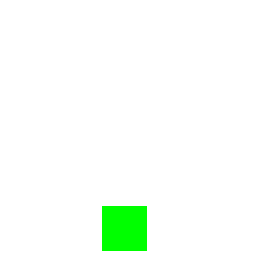

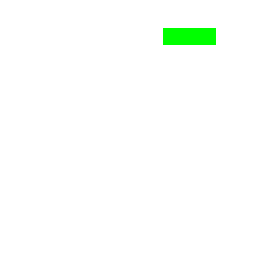

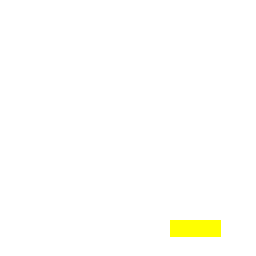

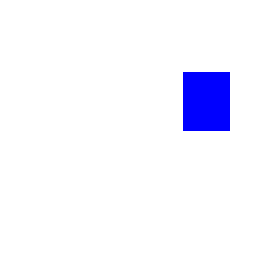

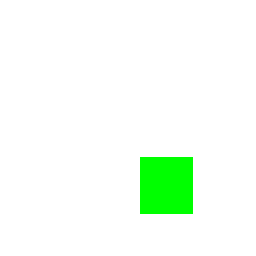

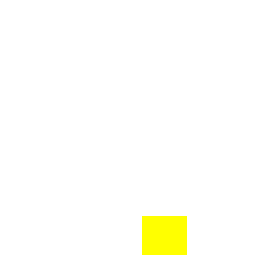

In [18]:
for n in range(6):
  cv_imshow(train_img[n])

In [19]:
# Preprocess data
train_img = tf.keras.applications.vgg16.preprocess_input(train_img)
train_label_coord=train_label_coord.astype(np.float32)
train_label_coord[:,0]=train_label_coord[:,0]/W
train_label_coord[:,1]=train_label_coord[:,1]/H
train_label_size=train_label_size.astype(np.float32)
train_label_size[:,0]=train_label_size[:,0]/(W/4)
train_label_size[:,1]=train_label_size[:,1]/(H/4)

# Build model
base_model = tf.keras.applications.VGG16(input_shape=[H,W,3], include_top=False,weights='imagenet')

x = base_model.output
x = tf.keras.layers.Flatten()(x)
out_coord=tf.keras.layers.Dense(2,activation='sigmoid',name='out_coord')(x)
out_size=tf.keras.layers.Dense(2, activation='sigmoid',name='out_size')(x)
out_class=tf.keras.layers.Dense(4,activation='softmax',name='out_class')(x)
model=tf.keras.Model(inputs=base_model.input,outputs=[out_coord,out_size,out_class])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 256, 256, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

In [27]:
# Train and save model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
loss={'out_coord':'mse','out_size':'mse','out_class':'sparse_categorical_crossentropy'},
loss_weights={'out_coord':4,'out_size':1,'out_class':1})
history = model.fit(x=train_img,
y={'out_coord':train_label_coord,'out_size':train_label_size,'out_class':train_label_class},
epochs=15,batch_size=70,validation_split=0.26)
model.save('model')

Epoch 1/15
22/22 [==============================] - 52s 2s/step - loss: 0.6701 - out_coord_loss: 0.0236 - out_size_loss: 0.0794 - out_class_loss: 0.4963 - val_loss: 0.1514 - val_out_coord_loss: 0.0185 - val_out_size_loss: 0.0633 - val_out_class_loss: 0.0141
Epoch 2/15
22/22 [==============================] - 29s 1s/step - loss: 0.0877 - out_coord_loss: 0.0106 - out_size_loss: 0.0366 - out_class_loss: 0.0088 - val_loss: 0.0610 - val_out_coord_loss: 0.0067 - val_out_size_loss: 0.0267 - val_out_class_loss: 0.0075
Epoch 3/15
22/22 [==============================] - 28s 1s/step - loss: 0.0369 - out_coord_loss: 0.0043 - out_size_loss: 0.0167 - out_class_loss: 0.0029 - val_loss: 0.0352 - val_out_coord_loss: 0.0040 - val_out_size_loss: 0.0163 - val_out_class_loss: 0.0029
Epoch 4/15
22/22 [==============================] - 29s 1s/step - loss: 0.0201 - out_coord_loss: 0.0023 - out_size_loss: 0.0092 - out_class_loss: 0.0016 - val_loss: 0.0216 - val_out_coord_loss: 0.0023 - val_out_size_loss: 0.01

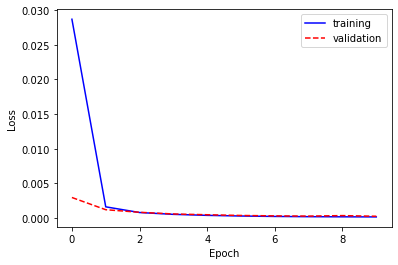

In [ ]:
#15장 46페이지까지 함
# Show training history
plt.figure()
plt.plot(history.history['loss'], 'b-', label='training')
plt.plot(history.history['val_loss'], 'r--', label='validation')
plt.xlabel('Epoch'), plt.ylabel('Loss'), plt.legend()
plt.show()

In [29]:
#48페이지부터 하던중 밑에 사각형으로 다 변경하ㅏ고 색상값 수정
#평가영상 생성
N=30
H,W=256,256
test_img=np.zeros([N,H,W,3],dtype=np.uint8)
test_img.fill(255)
test_label_coord=np.zeros([N,2],dtype=np.int32)
test_label_size=np.zeros([N,2],dtype=np.int32)
test_label_class=np.zeros([N,1],dtype=np.int32)

for n in range(N):
  x,y=random.randint(0,W-1),random.randint(0,H-1)
  bw,bh=random.randint(int(W/16),int(W/4)),random.randint(int(H/16),int(H/4))
  if(x-bw/2<0): x=x-(x-bw/2)
  elif(x+bw/2>W-1): x=x-(x+bw/2-(W-1))
  if(y-bh/2<0): y=y-(y-bh/2)
  elif(y+bh/2>H-1): y=y-(y+bh/2-(H-1))

  x=int(x); y=int(y)
  test_label_coord[n,0]=x; test_label_coord[n,1]=y
  test_label_size[n,0]=bw; test_label_size[n,1]=bh
  test_label_class[n]=random.randint(0,3) # 0: diamond, 1: rectangle, 2: ellipse
  if test_label_class[n]==0: # diamond
    cv.rectangle(test_img[n],(x-int(bw/2),y-int(bh/2)),(x+int(bw/2),y+int(bh/2)),color=(0,0,255),thickness=-1)
  elif train_label_class[n]==1: # rectangle
    cv.rectangle(test_img[n],(x-int(bw/2),y-int(bh/2)),(x+int(bw/2),y+int(bh/2)),color=(0,255,0),thickness=-1)
  elif train_label_class[n]==2: # rectangle
    cv.rectangle(test_img[n],(x-int(bw/2),y-int(bh/2)),(x+int(bw/2),y+int(bh/2)),color=(255,0,0),thickness=-1)
  else: # ellipse
    cv.rectangle(test_img[n],(x-int(bw/2),y-int(bh/2)),(x+int(bw/2),y+int(bh/2)),color=(0,255,255),thickness=-1)

In [30]:
# Preprocess test images
test_img_ = tf.keras.applications.vgg16.preprocess_input(test_img)
# Predict object locations in test images
model=tf.keras.models.load_model('model')
pred_coord,pred_size,pred_class=model.predict(test_img_)
pred_coord[:,0]=pred_coord[:,0]*W
pred_coord[:,1]=pred_coord[:,1]*H
pred_size[:,0]=pred_size[:,0]*(W/4)
pred_size[:,1]=pred_size[:,1]*(H/4)
pred_class=np.argmax(pred_class,axis=1)

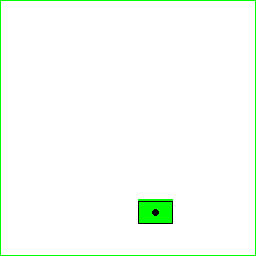

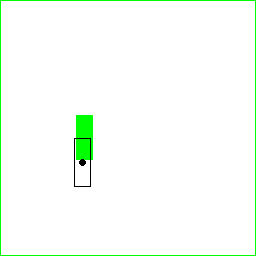

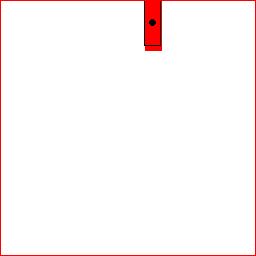

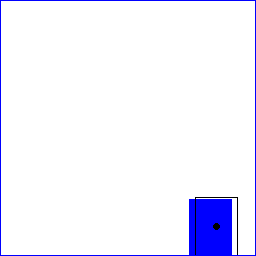

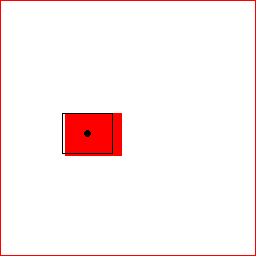

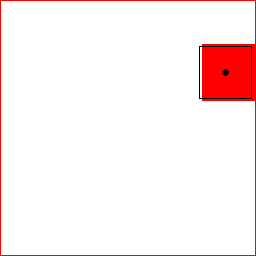

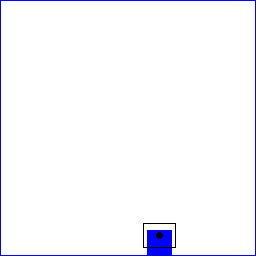

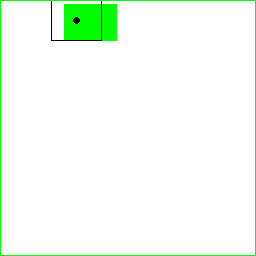

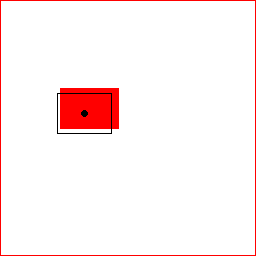

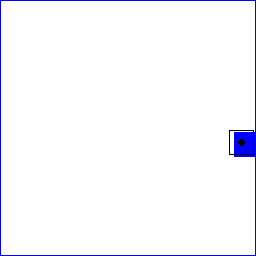

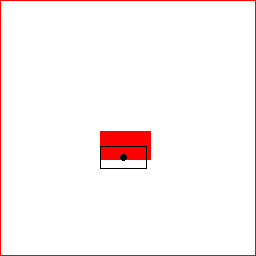

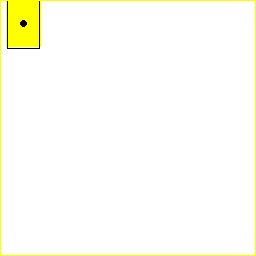

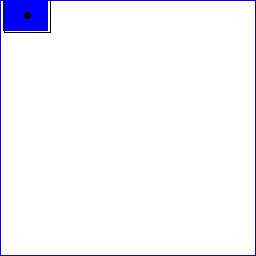

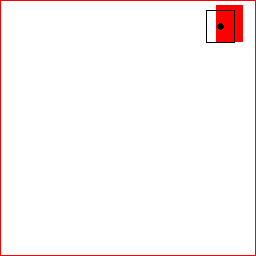

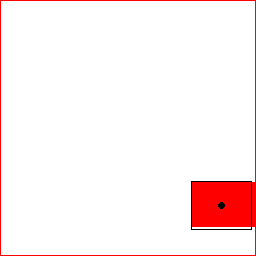

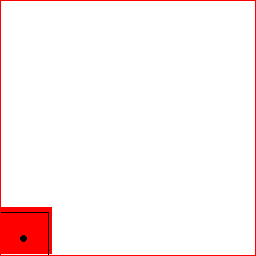

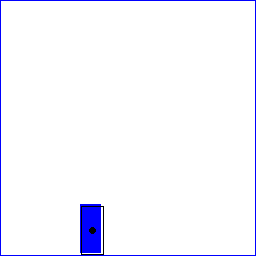

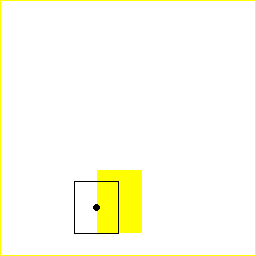

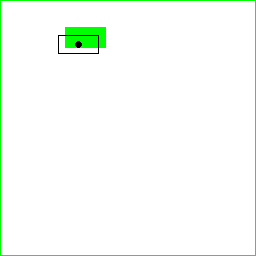

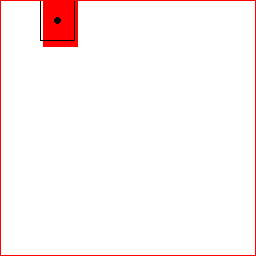

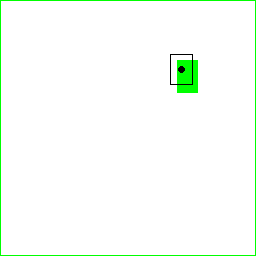

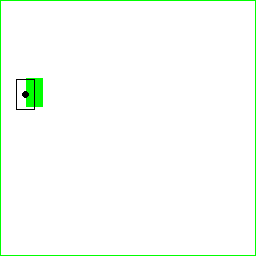

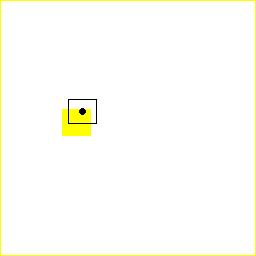

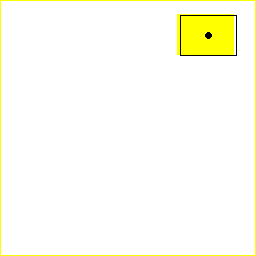

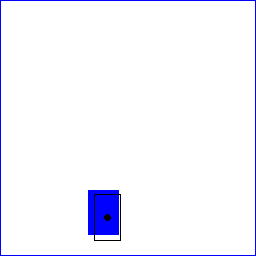

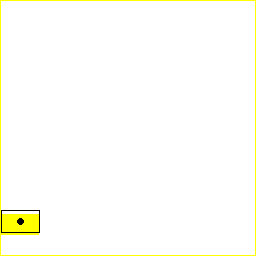

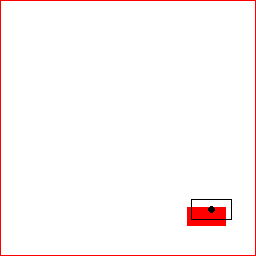

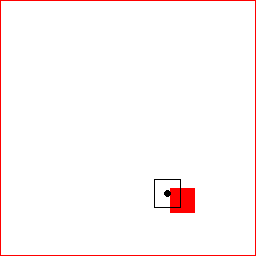

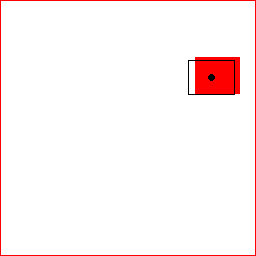

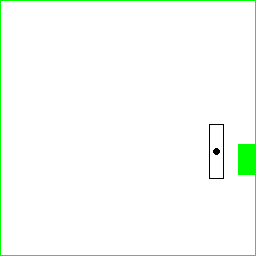

In [31]:
# Display prediction results
for n in range(N):
  x=pred_coord[n,0].astype('int')
  y=pred_coord[n,1].astype('int')
  bw=pred_size[n,0].astype('int')
  bh=pred_size[n,1].astype('int')
  obj_class=pred_class[n]

  if obj_class==0: # diamond
    cv.rectangle(test_img[n],(x-int(bw/2),y-int(bh/2)),(x+int(bw/2),y+int(bh/2)),color=(0,0,0),thickness=1)
    cv.rectangle(test_img[n],(0,0),(W-1,H-1),color=(0,0,255),thickness=1)
  elif obj_class==1: # rectangle
    cv.rectangle(test_img[n],(x-int(bw/2),y-int(bh/2)),(x+int(bw/2),y+int(bh/2)),color=(0,0,0),thickness=1)
    cv.rectangle(test_img[n],(0,0),(W-1,H-1),color=(0,255,0),thickness=1)
  elif obj_class==2: # rectangle
    cv.rectangle(test_img[n],(x-int(bw/2),y-int(bh/2)),(x+int(bw/2),y+int(bh/2)),color=(0,0,0),thickness=1)
    cv.rectangle(test_img[n],(0,0),(W-1,H-1),color=(255,0,0),thickness=1)
  else: # ellipse
   cv.rectangle(test_img[n],(x-int(bw/2),y-int(bh/2)),(x+int(bw/2),y+int(bh/2)),color=(0,0,0),thickness=1)
   cv.rectangle(test_img[n],(0,0),(W-1,H-1),color=(0,255,255),thickness=1)
  cv.circle(test_img[n],center=(x,y),radius=2,color=(0,0,0),thickness=2)
  cv_imshow(test_img[n])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 4)                 132       
                                                                 
Total params: 110,948
Trainable params: 110,948
Non-trainable params: 0
_________________________________________________________________


Epoch 1/3
200/200 [==============================] - 4s 4ms/step - loss: 0.0124 - accuracy: 0.9948
Epoch 2/3
200/200 [==============================] - 1s 3ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 3/3
200/200 [==============================] - 1s 3ms/step - loss: 0.0011 - accuracy: 1.0000


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 20)        520       
                                                                 
 activation (Activation)     (None, 28, 28, 20)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 20)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 50)        25050     
                                                                 
 activation_1 (Activation)   (None, 14, 14, 50)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 50)         0         
 2D)                                                  

Epoch 1/3
48/48 [==============================] - 9s 6ms/step - loss: 0.0044 - accuracy: 0.9973
Epoch 2/3
48/48 [==============================] - 0s 5ms/step - loss: 6.0860e-23 - accuracy: 1.0000
Epoch 3/3
48/48 [==============================] - 0s 5ms/step - loss: 4.9995e-23 - accuracy: 1.0000


188/188 [==============================] - 1s 3ms/step - loss: 4.9983e-23 - accuracy: 1.0000


[4.998337553628131e-23, 1.0]

In [ ]:
Lenet.evaluate(test_X2, test_Yc2)

32/32 [==============================] - 0s 4ms/step - loss: 5.6065e-28 - accuracy: 1.0000


[5.606511586900004e-28, 1.0]

0

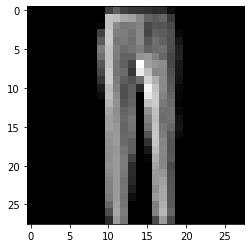

In [ ]:
for n in range(N):
  x,y=random.randint(0,W-1),random.randint(0,H-1)
  if(x-bw/2<0):
    x=x-(x-bw/2)
  elif(x+bw/2>W-1):
    x=x-(x+bw/2-(W-1))
  if(y-bh/2<0):
    y=y-(y-bh/2)
  elif(y+bh/2>H-1):
    y=y-(y+bh/2-(H-1))
  x=int(x)
  y=int(y)
  train_label[n,0]=x
  train_label[n,1]=y
  cv.rectangle(train_img[n], (x-int(bw/2),y-int(bh/2)), (x+int(bw/2),y+int(bh/2)),
  color=(0,255,0),thickness=-1)

  #단순테스트용

553476096/553467096 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
import tensorflow as tf
import numpy as np
from google.colab.patches import cv_imshow
import matplotlib.pyplot as plt
# Load CIFAR-10 Dataset
(train_X, train_Y), (test_X, test_Y) = tf.keras.datasets.cifar10.load_data()


In [ ]:
#idx=[]
#testidx=[]
#print(np.where(train_Y== 1))
#print(np.where(train_Y== 4))
idx = (np.where(train_Y== 0) \ np.where(train_Y== 1) \ np.where(train_Y== 8))
print(idx[0])

train_Y2=train_Y[idx[0]]
train_X2=train_X[idx[0]]
print(train_X2.shape)
testidx= (np.where(test_Y== 0) or np.where(test_Y== 1) or np.where(test_Y== 8))

test_X2=test_X[testidx[0]]
test_Y2=test_Y[testidx[0]]



SyntaxError: ignored

In [ ]:

train_Y2[np.where(train_Y2==8)]=2


test_Y2[np.where(test_Y2==8)]=2

In [ ]:
print(train_X.shape, test_X.shape)
print(np.where(train_Y== 1))
trainidx = array[1][0]
np.where()

(50000, 32, 32, 3) (10000, 32, 32, 3)
(array([    4,     5,    32, ..., 49993, 49998, 49999]), array([0, 0, 0, ..., 0, 0, 0]))


NameError: ignored

In [ ]:
model = tf.keras.applications.VGG16(include_top=False)
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
base_model = tf.keras.applications.VGG16(input_shape=[32,32,3],
include_top=False, weights='imagenet')
x = base_model.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
predictions = tf.keras.layers.Dense(3, activation='softmax')(x)
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

#for layer in model.layers:
# layer.trainable = True
for layer in model.layers[:19]:
 layer.trainable = False
for layer in model.layers[19:]:
 layer.trainable = True



In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_X2, train_Y2, batch_size=30, epochs=5, validation_split=0.25)

Epoch 1/5
125/125 [==============================] - 5s 16ms/step - loss: 0.3849 - accuracy: 0.9835 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/5
125/125 [==============================] - 1s 12ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/5
125/125 [==============================] - 1s 12ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/5
125/125 [==============================] - 1s 12ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/5
125/125 [==============================] - 1s 12ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


In [ ]:
model.evaluate(train_X2, train_Y2, verbose=False)

[0.0, 1.0]

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(test_X2, test_Y2, batch_size=30, epochs=5, validation_split=0.25)

Epoch 1/5
25/25 [==============================] - 2s 46ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/5
25/25 [==============================] - 0s 15ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/5
25/25 [==============================] - 0s 13ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/5
25/25 [==============================] - 0s 13ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/5
25/25 [==============================] - 0s 12ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


In [ ]:
base_model = tf.keras.applications.VGG16(input_shape=[32,32,3],
include_top=False, weights='imagenet')
x = base_model.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
predictions = tf.keras.layers.Dense(3, activation='softmax')(x)
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

for layer in model.layers:
 layer.trainable = True

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_X2, train_Y2, batch_size=30, epochs=5, validation_split=0.25)

Epoch 1/5
125/125 [==============================] - 6s 37ms/step - loss: 0.1913 - accuracy: 0.9925 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/5
125/125 [==============================] - 4s 30ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/5
125/125 [==============================] - 4s 30ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/5
125/125 [==============================] - 4s 30ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/5
125/125 [==============================] - 4s 30ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(test_X2, test_Y2, batch_size=36, epochs=5, validation_split=0.25)

Epoch 1/5
21/21 [==============================] - 7s 93ms/step - loss: 0.4975 - accuracy: 0.9653 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/5
21/21 [==============================] - 1s 33ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/5
21/21 [==============================] - 1s 33ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/5
21/21 [==============================] - 1s 33ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/5
21/21 [==============================] - 1s 33ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
